<a href="https://www.kaggle.com/code/vanpatangan/forecast-bitcoin-future-price?scriptVersionId=237694544" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import libraries and files

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import file
btc_hour = pd.read_csv('/kaggle/input/bitcoin-historical-datasets-2018-2024/btc_1h_data_2018_to_2025.csv')
btc_day = pd.read_csv('/kaggle/input/bitcoin-historical-datasets-2018-2024/btc_1d_data_2018_to_2025.csv')
btc_four = pd.read_csv('/kaggle/input/bitcoin-historical-datasets-2018-2024/btc_4h_data_2018_to_2025.csv')

# Concatenate files
btc_data = pd.concat([btc_day, btc_four, btc_hour], axis=0, ignore_index=True)

# Explore and preprocess 

In [3]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82945 entries, 0 to 82944
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Open time                     82945 non-null  object 
 1   Open                          82945 non-null  float64
 2   High                          82945 non-null  float64
 3   Low                           82945 non-null  float64
 4   Close                         82945 non-null  float64
 5   Volume                        82945 non-null  float64
 6   Close time                    82945 non-null  object 
 7   Quote asset volume            82945 non-null  float64
 8   Number of trades              82945 non-null  int64  
 9   Taker buy base asset volume   82945 non-null  float64
 10  Taker buy quote asset volume  82945 non-null  float64
 11  Ignore                        82945 non-null  int64  
dtypes: float64(8), int64(2), object(2)
memory usage: 7.6+ MB


In [4]:
# Select only date and close columns 
btc_data = btc_data[['Open time', 'Close', 'Volume']].copy()

# Rename the columns 
btc_data = btc_data.rename(columns={'Open time': 'ds', 'Close': 'y', 'Volume': 'volume'})

# Convert format to datetime  and remove timezones
btc_data['ds'] = pd.to_datetime(btc_data['ds'], errors='coerce').dt.tz_localize(None)

# Check the range of dates
print(btc_data['ds'].min(), btc_data['ds'].max())


2018-01-01 00:00:00 2025-05-04 00:00:00


In [5]:
# Convert y column to float type for numerical operations 
btc_data['y'] = btc_data['y'].astype(float)

# Remove rows containing NaN
btc_data.dropna(inplace=True)

In [6]:
btc_data

,ds,y,volume
0,2018-01-01,13380.00,8609.915844
1,2018-01-02,14675.11,20078.092111
2,2018-01-03,14919.51,15905.667639
3,2018-01-04,15059.54,21329.649574
4,2018-01-05,16960.39,23251.491125
...,...,...,...
2676,2025-04-30,94503.40,827.136240
2677,2025-05-01,94708.00,862.146700
2678,2025-05-02,97003.68,1243.522750
2679,2025-05-03,96474.89,1019.526420


# Modeling and prediction

In [7]:
# Initialize model
model = Prophet()

# Train model
model.fit(btc_data)

08:18:53 - cmdstanpy - INFO - Chain [1] start processing
08:18:54 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
# Create a dataframe for forecasting a year after the training data ends 
future = model.make_future_dataframe(periods=365)

In [9]:
# Use trained model for prediction
forecast = model.predict(future)

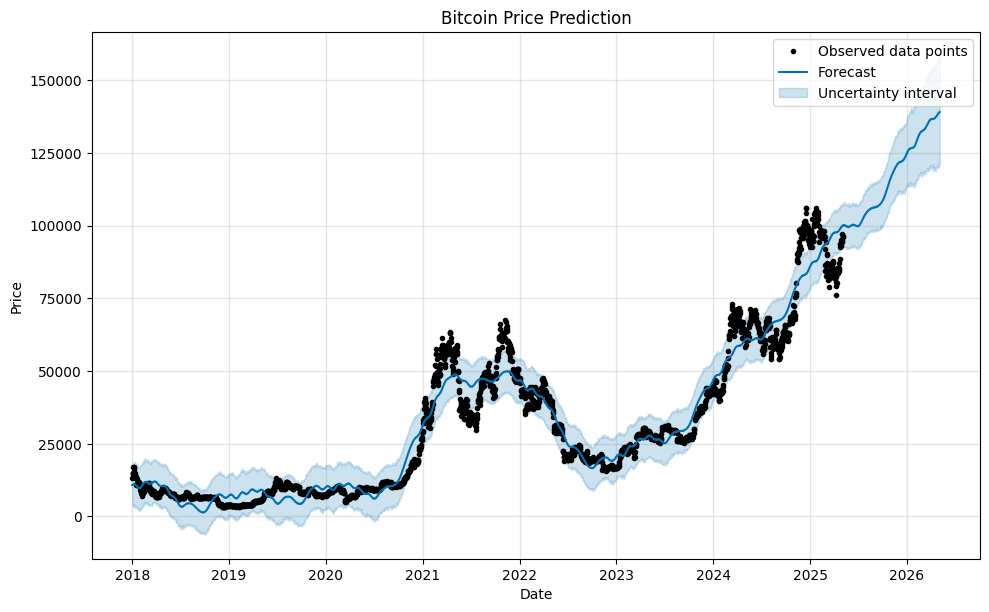

In [10]:
# Visualize forecast
fig = model.plot(forecast)
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [11]:
# Show last 5 predicted prices
forecast[['ds','yhat', 'yhat_upper','yhat_lower']].tail()

,ds,yhat,yhat_upper,yhat_lower
3041,2026-04-30,138646.109955,157465.227170,121056.016076
3042,2026-05-01,138769.785415,157821.742740,120651.735198
3043,2026-05-02,138866.075684,157611.131919,120069.904169
3044,2026-05-03,138946.674003,158319.184089,121844.526924
3045,2026-05-04,139035.946118,158022.388533,121160.484618


In [12]:
# Calculate Residuals
btc_data['residuals'] = btc_data['y'] - forecast['yhat']

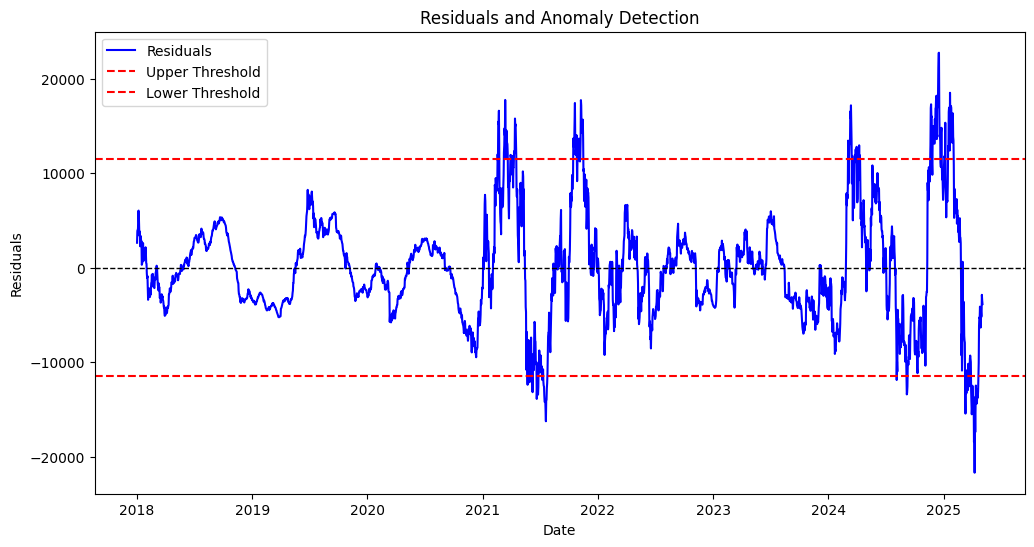

In [13]:
# Plot Residuals
plt.figure(figsize=(12, 6))
plt.plot(btc_data['ds'], btc_data['residuals'], label='Residuals', color='blue')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.axhline(y=2 * btc_data['residuals'].std(), color='red', linestyle='--', label='Upper Threshold')
plt.axhline(y=-2 * btc_data['residuals'].std(), color='red', linestyle='--', label='Lower Threshold')
plt.title('Residuals and Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

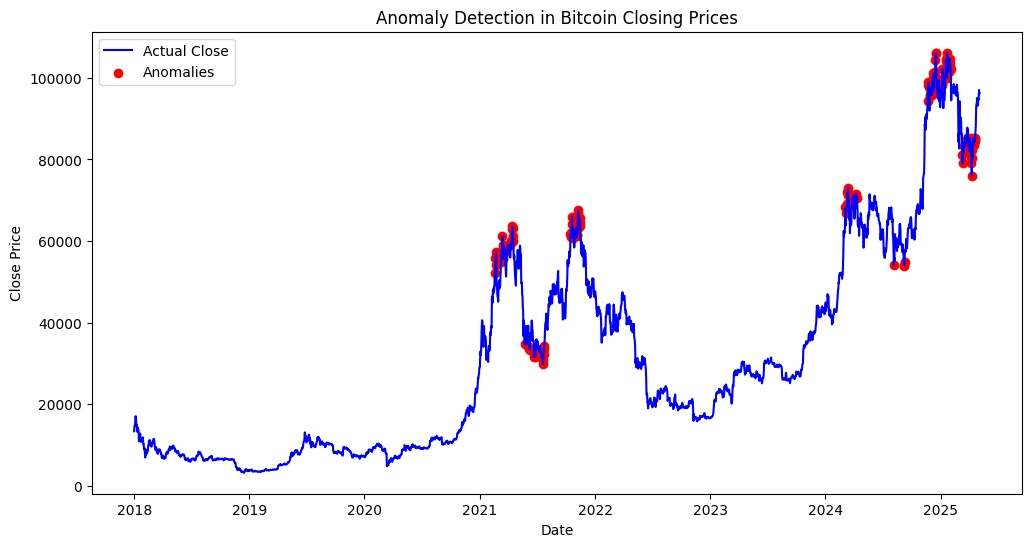

In [14]:
# Use 2 standard deviations threshold to flag anomalies
threshold = 2 * btc_data['residuals'].std()
btc_data['is_anomaly'] = (btc_data['residuals'] > threshold) | (btc_data['residuals'] < -threshold)

# Visualize Anomalies
plt.figure(figsize=(12, 6))
plt.plot(btc_data['ds'], btc_data['y'], label='Actual Close', color='blue')
plt.scatter(btc_data[btc_data['is_anomaly']]['ds'], 
            btc_data[btc_data['is_anomaly']]['y'], 
            color='red', label='Anomalies')
plt.title('Anomaly Detection in Bitcoin Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


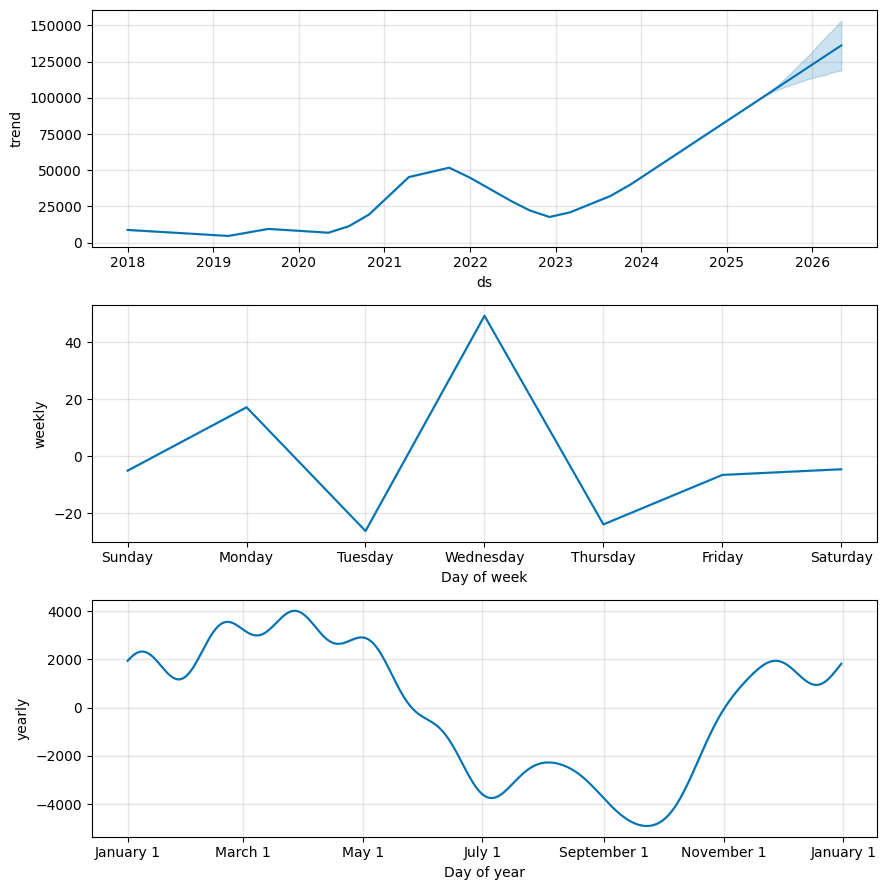

In [15]:
# Visualize trends and seasonality components 
fig = model.plot_components(forecast)